In [1]:
import numpy as np
import xtrack as xt
import xobjects as xo
import xpart as xp
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import constants 


line = xt.Line.from_json('sps.json')
particle_ref=line.particle_ref

line.build_tracker()
#line.freeze_longitudinal()
# line.optimize_for_tracking()

twiss=line.twiss()

clight=constants.speed_of_light
circumference = line.get_length()

#%%
###################
# Linear Transfer #
###################

qx=twiss['qx']
qy=twiss['qy']
dqx=twiss['dqx']
dqy=twiss['dqy']
circumference=twiss['s'][-1]
# beta_x=twiss['betx'][-1]
# beta_y=twiss['bety'][-1]

qs=twiss['qs']
bets=twiss['betz0']


#at interaction points: #from https://anaconda.org/petrenko/li_like_ca_in_sps/notebook
beta_x  =  54.614389 # m
beta_y  =  44.332517 # m
alpha_x = -1.535235
alpha_y =  1.314101



Dx  =  2.444732 # m
Dpx =  0.097522


Dy  =  0.0 # m
Dpy =  0.0

#index of gamma factory along SPS line: 16675

arc = xt.LineSegmentMap(
        qx=qx, qy=qy,
        dqx=0, dqy=0,
        length=circumference,
        alfx=alpha_x,
        alfy=alpha_y,
        betx=beta_x,
        bety=beta_y,
        
        dx=Dx,
        dpx=Dpx,
        dy=Dy,
        dpy=Dpy,
        qs=qs,
        bets=bets,
        )


/home/pkruyt/cernbox/xsuite-laser/xtrack/xtrack/progress_indicator.py:90: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [2]:
from ion_properties import ions,lead,calcium,xenon

ion=calcium

In [3]:
for ion in [lead]:# Ion properties:

        gamma_list=np.linspace(ion.gamma_rel*(1-2e-4),ion.gamma_rel*(1+2e-4),25)
        gamma_list=np.linspace(96.07383329737414,96.08343403359551,25)
        final_emittance_list = []
        final_dp_p=[]
        # cooler_growth_rates_list=[]
        # cooler_heating_growth_rates_list=[]
        transverse_growth_rate_list=[]
        longitudinal_growth_rate_list=[]

        from scipy.optimize import curve_fit

        plt.figure(figsize=(12, 8))
        plt.rcParams.update({'font.size': 25})

        # Ion properties:
        q0 = ion.q0
        mass0 = ion.mass0

        for gamma_loop in tqdm(gamma_list):

                #gamma = ion.gamma_rel
                gamma = gamma_loop
                beta=  np.sqrt(1-1/(gamma*gamma))
                p0c = mass0*gamma*beta #eV/c

                bunch_intensity = ion.Intensity

                particle_ref = xp.Particles(p0c=p0c, mass0=mass0, q0=q0,gamma0=gamma)

                line.particle_ref=particle_ref


                nemitt = 1.5e-6 # m*rad (normalized emittance)
                sigma_z = 0.063 # m

                emittance=nemitt/(beta*gamma)

                num_particles=int(5e3)

                line_arc=xt.Line(
                        elements=[arc])
                line_arc.build_tracker()

                particles = xp.generate_matched_gaussian_bunch(
                        num_particles=num_particles,
                        total_intensity_particles=bunch_intensity,
                        nemitt_x=nemitt, nemitt_y=nemitt, sigma_z=sigma_z,
                        particle_ref=particle_ref,
                        line=line_arc,        
                        )

                particles0=particles.copy()
                # sigma_dp=2e-4  
                sigma_dp=np.std(particles.delta)
                print(sigma_dp)
                sigma_dp=2e-4  
                ##################
                # Laser Cooler #
                ##################

                #laser-ion beam collision angle
                theta_l = 2.6*np.pi/180 # rad
                nx = 0; ny = -np.sin(theta_l); nz = -np.cos(theta_l)

                # Ion excitation energy:
                ion_excited_lifetime=ion.excited_lifetime
                hw0 = ion.hw0 # eV
                hc=constants.hbar*clight/constants.e # eV*m (ħc)
                lambda_0 = 2*np.pi*hc/hw0 # m -- ion excitation wavelength

                lambda_l = ion.lambda_l

                # # Shift laser wavelength for fast longitudinal cooling:5
                # lambda_l = lambda_l*(1+1*sigma_dp) # m

                laser_frequency = clight/lambda_l # Hz
                sigma_w = 2*np.pi*laser_frequency*sigma_dp
                #sigma_w = 2*np.pi*laser_frequency*sigma_dp/2 # for fast longitudinal cooling

                sigma_t = 1/sigma_w # sec -- Fourier-limited laser pulse
                print('Laser pulse duration sigma_t = %.2f ps' % (sigma_t/1e-12))
                print('Laser wavelength = %.2f nm' % (lambda_l/1e-9))

                laser_waist_radius = 1.3e-3 #m
                laser_energy = 5e-3

                laser_x=-1*1e-3

                #sigma_t=sigma_t*0.70 # to get 1.9 ps
                # sigma_t=1.9e-12

                GF_IP = xt.PulsedLaser(
                                laser_x=-1.7346938775510203*1e-3,
                                laser_y=0,
                                laser_z=0,
                                
                                laser_direction_nx = 0,
                                laser_direction_ny = ny,
                                laser_direction_nz = nz,
                                laser_energy         = laser_energy, # J
                                laser_duration_sigma = sigma_t, # sec
                                laser_wavelength = lambda_l, # m
                                laser_waist_radius = laser_waist_radius, # m
                                laser_waist_shift = 0, # m
                                ion_excitation_energy = hw0, # eV
                                ion_excited_lifetime  = ion_excited_lifetime, # sec                   
                                )

                # simulation parameters: simulate 10 s of cooling, and take data once every 100 ms
                max_time_s = 0.6
                int_time_s = 0.01
                T_per_turn = circumference/(clight*beta)
                num_turns = int(max_time_s/T_per_turn)
                save_interval = int(int_time_s/T_per_turn)

                # num_turns = int(1e3)
                # save_interval = num_turns/100
                # # save_interval=1

                # create a monitor object, to reduce holded data
                monitor = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1,
                                        n_repetitions=int(num_turns/save_interval),
                                        repetition_period=save_interval,
                                        num_particles=num_particles)


                # line.discard_tracker()
                # IP_index=16675   
                # line.insert_element('monitor', element=monitor, index=IP_index)
                # line.insert_element('GF_IP', element=GF_IP, index=IP_index) #this way monitor comes after the laser
                # SPS_line.append_element(monitor,'monitor')
                # SPS_line.append_element(GF_IP,'GF_IP')
                
                
                particles=particles0.copy()

                line = xt.Line(
                        elements=[monitor,GF_IP,arc])

                context = xo.ContextCpu(omp_num_threads=1)
                line.build_tracker(_context=context)
                # line.optimize_for_tracking()

                line.track(particles, num_turns=num_turns,
                        turn_by_turn_monitor=False,with_progress=True)

                # extract relevant values
                x = monitor.x[:,:,0]
                px = monitor.px[:,:,0]
                y = monitor.y[:,:,0]
                py = monitor.py[:,:,0]
                delta = monitor.delta[:,:,0]
                zeta = monitor.zeta[:,:,0]
                state = monitor.state[:,:,0]
                time = monitor.at_turn[:, 0, 0] * T_per_turn

                gamma_x=(1+alpha_x**2)/beta_x
                gamma_y=(1+alpha_y**2)/beta_y

                action_x = (gamma_x*(x-Dx*delta)**2 + 2*alpha_x*(x-Dx*delta)*(px-Dpx*delta)+ beta_x*(px-Dpx*delta)**2)
                action_y = (gamma_y*(y-Dy*delta)**2 + 2*alpha_y*(y-Dy*delta)*(py-Dpy*delta)+ beta_y*(py-Dpy*delta)**2)

                emittance_x=np.mean(action_x,axis=1)*gamma/2

                # Define the exponential function
                def exponential_func(x, a, b):
                        return a * np.exp(x * b)
                
                # Fit the data to the exponential function
                params_transverse, covariance = curve_fit(exponential_func, time, emittance_x)

                # Extract the parameters
                a, b = params_transverse

                transverse_growth_rate_list.append(b)

                final_emittance_list.append(emittance_x[-1])

                # plt.plot(time,emittance_x*1e6, linewidth=5.0)
                # plt.plot(time, exponential_func(time,
                # *params_transverse) * 1e6, linestyle='--')
                
                # Fit the data to the exponential function
                rms_dp_p = np.std(delta, axis=1)
                window_size = 10  # or any other suitable value
                rms_dp_p_smoothed = np.convolve(rms_dp_p, np.ones(window_size)/window_size, mode='valid')


                params_longitudinal, covariance = curve_fit(exponential_func, time[:len(rms_dp_p_smoothed)], rms_dp_p_smoothed)

                # Extract the parameters
                a, b = params_longitudinal

                longitudinal_growth_rate_list.append(b)

                final_dp_p.append(rms_dp_p[-1])


        np.savez(f'results/optimal_gamma/{ion.name}.npz', transverse_growth_rate_list=transverse_growth_rate_list,
                longitudinal_growth_rate_list=longitudinal_growth_rate_list,final_dp_p=final_dp_p,
                final_emittance_list=final_emittance_list,gamma_list=gamma_list,nemitt=nemitt,time=time)


  0%|          | 0/25 [00:00<?, ?it/s]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
0.00019943453844261167
Laser pulse duration sigma_t = 2.74 ps
Laser wavelength = 1031.80 nm
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

  4%|▍         | 1/25 [00:37<15:00, 37.51s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
0.00019928497525673253
Laser pulse duration sigma_t = 2.74 ps
Laser wavelength = 1031.80 nm
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

  8%|▊         | 2/25 [01:15<14:32, 37.94s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
0.00020060806694337065
Laser pulse duration sigma_t = 2.74 ps
Laser wavelength = 1031.80 nm
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 12%|█▏        | 3/25 [01:53<13:53, 37.89s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
0.00020005132651724976
Laser pulse duration sigma_t = 2.74 ps
Laser wavelength = 1031.80 nm
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 16%|█▌        | 4/25 [02:31<13:12, 37.73s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
0.0002014266844443132
Laser pulse duration sigma_t = 2.74 ps
Laser wavelength = 1031.80 nm
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 20%|██        | 5/25 [03:09<12:37, 37.89s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
0.0002030041454543673
Laser pulse duration sigma_t = 2.74 ps
Laser wavelength = 1031.80 nm
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 24%|██▍       | 6/25 [03:47<12:00, 37.94s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
0.00019761513620510129
Laser pulse duration sigma_t = 2.74 ps
Laser wavelength = 1031.80 nm
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 28%|██▊       | 7/25 [04:23<11:15, 37.51s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
0.0002033019213535734
Laser pulse duration sigma_t = 2.74 ps
Laser wavelength = 1031.80 nm
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 32%|███▏      | 8/25 [04:59<10:27, 36.94s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
0.00020079444403332803
Laser pulse duration sigma_t = 2.74 ps
Laser wavelength = 1031.80 nm
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 36%|███▌      | 9/25 [05:35<09:44, 36.54s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
0.00020365941814536598
Laser pulse duration sigma_t = 2.74 ps
Laser wavelength = 1031.80 nm
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 40%|████      | 10/25 [06:08<08:50, 35.38s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
0.00019753332381169787
Laser pulse duration sigma_t = 2.74 ps
Laser wavelength = 1031.80 nm
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 44%|████▍     | 11/25 [06:35<07:40, 32.90s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
0.00020073145773939332
Laser pulse duration sigma_t = 2.74 ps
Laser wavelength = 1031.80 nm
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 48%|████▊     | 12/25 [07:11<07:21, 33.93s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
0.00020185807457534903
Laser pulse duration sigma_t = 2.74 ps
Laser wavelength = 1031.80 nm
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 52%|█████▏    | 13/25 [07:47<06:55, 34.62s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
0.00020045476186181623
Laser pulse duration sigma_t = 2.74 ps
Laser wavelength = 1031.80 nm
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 56%|█████▌    | 14/25 [08:24<06:26, 35.16s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
0.00020171176465738158
Laser pulse duration sigma_t = 2.74 ps
Laser wavelength = 1031.80 nm
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 60%|██████    | 15/25 [08:59<05:52, 35.22s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
0.0001993153732511226
Laser pulse duration sigma_t = 2.74 ps
Laser wavelength = 1031.80 nm
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 64%|██████▍   | 16/25 [09:38<05:26, 36.25s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
0.00019895062079563672
Laser pulse duration sigma_t = 2.74 ps
Laser wavelength = 1031.80 nm
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 68%|██████▊   | 17/25 [10:13<04:47, 35.97s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
0.00019614069475927778
Laser pulse duration sigma_t = 2.74 ps
Laser wavelength = 1031.80 nm
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 72%|███████▏  | 18/25 [10:49<04:10, 35.85s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
0.00020109129745982048
Laser pulse duration sigma_t = 2.74 ps
Laser wavelength = 1031.80 nm
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 76%|███████▌  | 19/25 [11:24<03:34, 35.67s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
0.00020035194644814572
Laser pulse duration sigma_t = 2.74 ps
Laser wavelength = 1031.80 nm
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 80%|████████  | 20/25 [11:59<02:57, 35.55s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
0.00020146245431258307
Laser pulse duration sigma_t = 2.74 ps
Laser wavelength = 1031.80 nm
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 84%|████████▍ | 21/25 [12:34<02:21, 35.36s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
0.0002003293435280047
Laser pulse duration sigma_t = 2.74 ps
Laser wavelength = 1031.80 nm
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 88%|████████▊ | 22/25 [13:10<01:46, 35.42s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
0.00019909202637267355
Laser pulse duration sigma_t = 2.74 ps
Laser wavelength = 1031.80 nm
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 92%|█████████▏| 23/25 [13:45<01:10, 35.38s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
0.0002015447272082129
Laser pulse duration sigma_t = 2.74 ps
Laser wavelength = 1031.80 nm
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

 96%|█████████▌| 24/25 [14:17<00:34, 34.32s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
0.00020124528830504706
Laser pulse duration sigma_t = 2.74 ps
Laser wavelength = 1031.80 nm
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/26100 [00:00<?, ?it/s]

100%|██████████| 25/25 [14:53<00:00, 35.73s/it]


<Figure size 1200x800 with 0 Axes>

Transverse emittance

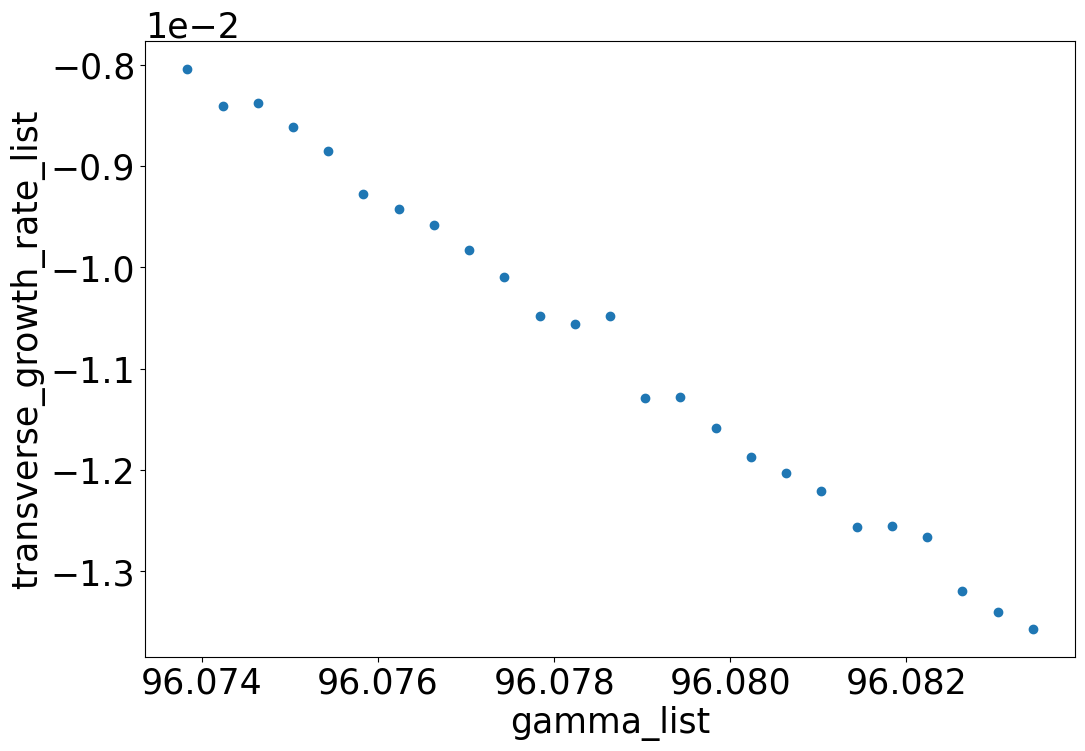

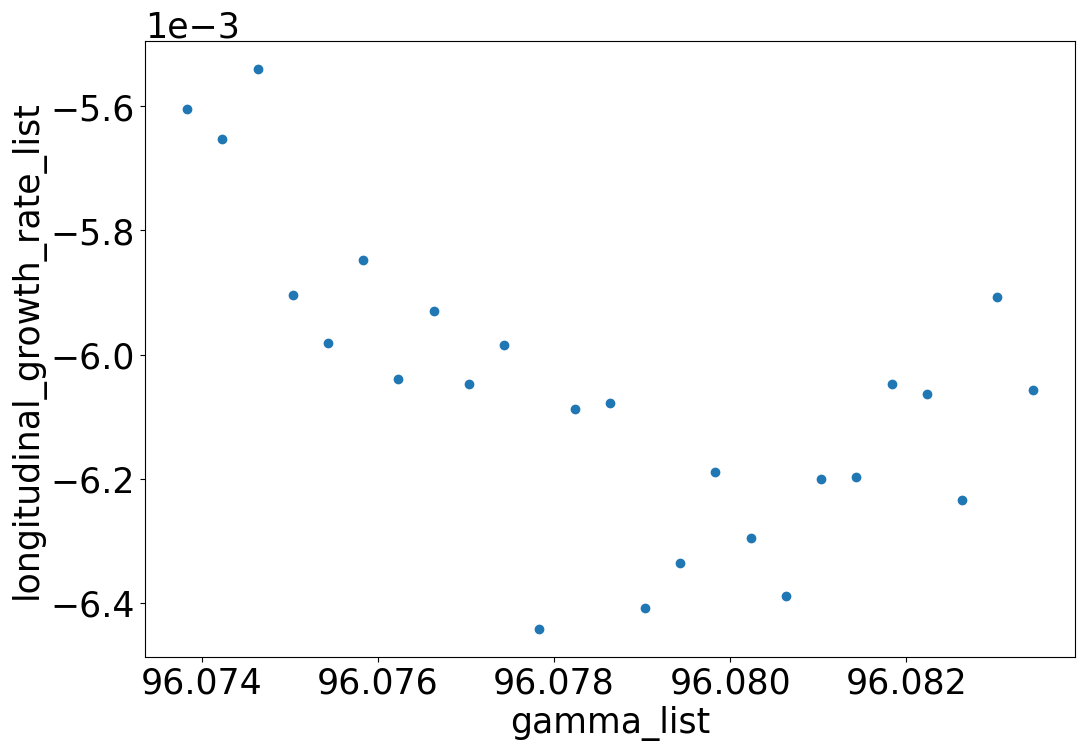

In [4]:
#
# plt.figure(figsize=(12, 8))
# plt.rcParams.update({'font.size': 25})
# plt.scatter(gamma_list,final_emittance_list)
# plt.xlabel('Horizontal laser offset [m]')
# plt.ylabel('Final emittance ')
# ax = plt.gca()
# # Removing the offset from the y-axis tick labels
# ax.yaxis.get_major_formatter().set_useOffset(False)
# # plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.show()

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.scatter(gamma_list,transverse_growth_rate_list)
plt.xlabel('gamma_list')
plt.ylabel('transverse_growth_rate_list')
ax = plt.gca()
# Removing the offset from the y-axis tick labels
ax.yaxis.get_major_formatter().set_useOffset(False)
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.savefig('Optimal_laser_offset.png',dpi=300)
plt.show()

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.scatter(gamma_list,longitudinal_growth_rate_list)
plt.xlabel('gamma_list')
plt.ylabel('longitudinal_growth_rate_list')
ax = plt.gca()
# Removing the offset from the y-axis tick labels
ax.yaxis.get_major_formatter().set_useOffset(False)
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.savefig('Optimal_laser_offset.png',dpi=300)
plt.show()

In [5]:
min_index = np.argmin(longitudinal_growth_rate_list)
min_value = longitudinal_growth_rate_list[min_index]
min_gamma = gamma_list[min_index]

print("Minimum value:", min_value)
print("Corresponding Horizontal laser offset:", min_gamma, "mm")

Minimum value: -0.006441680027124298
Corresponding Horizontal laser offset: 96.07783360413305 mm
